In [ ]:
# Copyright 2020 Google LLC
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# AI Platform (Unified) SDK: Training a custom image classification model using a training pipeline with a managed dataset input

<table align="left">
  <td>
    <a href="https://colab.research.google.com/github/GoogleCloudPlatform/ai-platform-samples/blob/master/notebooks/deepdive/custom/ucaip_customjob_image_pipeline.ipynb">
      <img src="https://cloud.google.com/ml-engine/images/colab-logo-32px.png" alt="Colab logo"> Run in Colab
    </a>
  </td>
  <td>
    <a href="https://github.com/GoogleCloudPlatform/ai-platform-samples/blob/master/notebooks/deepdive/custom/ucaip_customjob_image_pipeline.ipynb">
      <img src="https://cloud.google.com/ml-engine/images/github-logo-32px.png" alt="GitHub logo">
      View on GitHub
    </a>
  </td>
</table>

# Overview


This tutorial demonstrates how to use the AI Platform (Unified) Python SDK to train a custom image classification model using a [training pipeline job](https://cloud.google.com/ai-platform-unified/docs/training/create-training-pipeline) with a managed dataset input.

### Dataset

The dataset used for this tutorial is the [Flowers dataset](https://www.tensorflow.org/datasets/catalog/tf_flowers) from [TensorFlow Datasets](https://www.tensorflow.org/datasets/catalog/overview). The version of the dataset you will use in this tutorial is stored in a public Cloud Storage bucket. The trained model predicts the type of flower an image is from a class of five flowers: daisy, dandelion, rose, sunflower, tulip.

### Objectives


- Creating a AI Platform (Unified) dataset.
- Creating a training pipeline with a custom job training step and an AI Platform dataset input.
- Starting the training pipeline job.
- Monitoring the training pipeline job.
- Deploy the model to a serving endpoint.
- Make a prediction(s).
- Undeploy the model.

### Costs 

This tutorial uses billable components of Google Cloud Platform (GCP):

* Cloud AI Platform
* Cloud Storage

Learn about [Cloud AI Platform
pricing](https://cloud.google.com/ml-engine/docs/pricing) and [Cloud Storage
pricing](https://cloud.google.com/storage/pricing), and use the [Pricing
Calculator](https://cloud.google.com/products/calculator/)
to generate a cost estimate based on your projected usage.

### Environment

This notebook was developed and tested using [AI Platform Notebooks](https://cloud.google.com/ai-platform-notebooks) using the TensorFlow 2.3 image.

## Before you begin

### Set up your GCP project

**The following steps are required, regardless of your notebook environment.**

1. [Select or create a GCP project](https://console.cloud.google.com/cloud-resource-manager). When you first create an account, you get a $300 free credit towards your compute/storage costs.

2. [Make sure that billing is enabled for your project.](https://cloud.google.com/billing/docs/how-to/modify-project)

3. [Enable the AI Platform APIs, Compute Engine APIs and Container Registry API.](https://console.cloud.google.com/flows/enableapi?apiid=ml.googleapis.com,compute_component,containerregistry.googleapis.com)

4. Follow the instructions in the repos' [README file](https://github.com/jarokaz/ucaip/blob/main/README.md) to provision an instance of AI Platform Notebooks and install Cloud AI Platform (Unified) SDK.



#### Set your Project ID

**If you don't know your project ID**, you might be able to get your project ID using `gcloud` command by executing the second cell below.

In [1]:
PROJECT_ID = "jk-mlops-dev" 

In [2]:
! gcloud config set project $PROJECT_ID

Updated property [core/project].


#### Region

You can also change the `REGION` variable, which is used for operations
throughout the rest of this notebook. Make sure to [choose a region where Cloud
AI Platform services are
available](https://cloud.google.com/ml-engine/docs/tensorflow/regions). You can
not use a Multi-Regional Storage bucket for training with AI Platform.

In [3]:
REGION = 'us-central1' 

### Create a Cloud Storage bucket

Set the name of your Cloud Storage bucket below. It must be unique across all
Cloud Storage buckets. 

In [4]:
BUCKET_NAME = "jk-ucaip-demos" 

**Only if your bucket doesn't already exist**: Run the following cell to create your Cloud Storage bucket.

In [5]:
! gsutil mb -l $REGION gs://$BUCKET_NAME

Creating gs://jk-ucaip-demos/...
ServiceException: 409 Bucket jk-ucaip-demos already exists.


Finally, validate access to your Cloud Storage bucket by examining its contents:

In [6]:
! gsutil ls -al gs://$BUCKET_NAME

      1897  2021-02-09T06:29:04Z  gs://jk-ucaip-demos/trainer_cifar.tar.gz#1612852144799472  metageneration=1
                                 gs://jk-ucaip-demos/custom_job_20210209062832/
                                 gs://jk-ucaip-demos/image-classifier-pipeline/
TOTAL: 1 objects, 1897 bytes (1.85 KiB)


### Import libraries and define constants

In [7]:
%load_ext autoreload

#### Import AI Platform (Unified) SDK

Import the AI Platform (Unified) SDK into our python environment.

In [8]:
import base64
import json
import os
import sys
import time

import google.auth
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_io as tfio

from google.cloud.aiplatform import gapic as aip

from google.protobuf import json_format
from google.protobuf.struct_pb2 import Value

from datetime import datetime

### AI Platform (Unified) constants

Let's now setup some constants for AI Platform (Unified):

#### Endpoints

- `API_ENDPOINT`: The AI Platform (Unified) API service endpoint for dataset, model, job, pipeline and endpoint services.
- `API_PREDICT_ENDPOINT`: The AI Platform (Unified) API service endpoint for prediction.
- `PARENT`: The AI Platform (Unified) location root path for dataset, model and endpoint resources.

In [9]:
# API Endpoint
API_ENDPOINT = "us-central1-aiplatform.googleapis.com"
API_PREDICT_ENDPOINT = "us-central1-prediction-aiplatform.googleapis.com"

# AI Platform (Unified) location root path for your dataset, model and endpoint resources
PARENT = "projects/" + PROJECT_ID + "/locations/" + REGION

# Default timeout for API calls
TIMEOUT = 60

#### Dataset schemas

AI Platform supports four dataset types: tabular, text, image and video. The same dataset type can be used for multiple ML tasks. For example, the image dataset type can be used for single-label classification, multi-label classification or object detection. In this sample, you will create an image dataset for the single-label classificatin task.

The dataset type and the ML task are specified by a set of pre-defined YAML based schemas provided by AI Platform.

In [10]:
IMAGE_SCHEMA = 'gs://google-cloud-aiplatform/schema/dataset/metadata/image_1.0.0.yaml' 
IMPORT_SCHEMA_IMAGE_CLASSIFICATION = 'gs://google-cloud-aiplatform/schema/dataset/ioformat/image_classification_single_label_io_format_1.0.0.yaml'

#### Training pipeline schemas

When configuring a training pipeline you need to specify a type of a training task - a custom job or AutoML training. In addition, if your pipeline uses an AI Platform dataset as input, you have to specify a type of annotations to use for training - an AI Platform dataset can have multiple annotation types attached to the dataset. 

In our case, we will configure a pipeline with a custom training task and image dataset with image classification annotations.

In [11]:
ANNOTATION_SCHEMA = 'gs://google-cloud-aiplatform/schema/dataset/annotation/image_classification_1.0.0.yaml'
CUSTOM_TRAINING_TASK_DEFINITION = 'gs://google-cloud-aiplatform/schema/trainingjob/definition/custom_task_1.0.0.yaml'

#### Training and deployment container images

These constants define a base image for a custom training and a serving image.

In [12]:
TRAIN_BASE_IMAGE = 'gcr.io/deeplearning-platform-release/tf2-gpu.2-3:latest'
DEPLOY_IMAGE = 'gcr.io/cloud-aiplatform/prediction/tf2-cpu.2-2:latest'

#### Machine configurations for training and deployment

In [13]:
TRAIN_GPU, TRAIN_NGPU = (aip.AcceleratorType.NVIDIA_TESLA_K80, 1)
DEPLOY_GPU, DEPLOY_NGPU = (None, None)

TRAIN_MACHINE_TYPE = 'n1-standard-4'
DEPLOY_MACHINE_TYPE = 'n1-standard-4'

# Tutorial

## Clients

The AI Platform (Unified) SDK works as a client/server model. On your side, the python script, you will create a client that sends requests and receives responses from the server -- AI Platform.

You will use several clients in this tutorial, so set them all up upfront.

- Dataset Service for managed datasets.
- Model Service for managed models.
- Pipeline Service for training.
- Endpoint Service for deployment.
- Prediction Service for serving. *Note*, prediction has a different service endpoint.


In [14]:
# client options same for all services
client_options = {"api_endpoint": API_ENDPOINT}
predict_client_options = {"api_endpoint": API_PREDICT_ENDPOINT}

dataset_client = aip.DatasetServiceClient(client_options=client_options)
model_client = aip.ModelServiceClient(client_options=client_options)
pipeline_client = aip.PipelineServiceClient(client_options=client_options)
endpoint_client = aip.EndpointServiceClient(client_options=client_options)
prediction_client = aip.PredictionServiceClient(client_options=predict_client_options)

## Creating an AI Platform dataset

Creating an AI Platform dataset is a two-step process. The first step is to create an empty dataset. During the first step you define the dataset type. The second step is to import the data to the dataset. This is when you specify the ML task supported by the imported data.


### Create an empty image dataset

Both creating a dataset and importing data are long running operations in AI Platform. The long running operations use asynchronous calls. An asynchronous call does not block a caller and returns an `operation` object that can by subsequently used to monitor/control the operation by invoking methods exposed by the object:


| Method      | Description |
| ----------- | ----------- |
| result()    | Waits for the operation to complete and returns a result object in JSON format.      |
| running()   | Returns True/False on whether the operation is still running.        |
| done()      | Returns True/False on whether the operation is completed. |
| canceled()  | Returns True/False on whether the operation was canceled. |
| cancel()    | Cancels the operation (this may take up to 30 seconds). |



In [ ]:
display_name = 'flowers-dataset'

dataset = aip.Dataset(
    display_name=display_name,
    metadata_schema_uri=IMAGE_SCHEMA,
    labels=None
)

operation = dataset_client.create_dataset(parent=PARENT, dataset=dataset)
print("Long running operation:", operation.operation.name)
response = operation.result(timeout=TIMEOUT)
print(response)
dataset_name = response.name

### Prepare data for import

The data to be imported to an AI Platform image dataset must meet the following requirements:

- Images must be stored in a Cloud Storage bucket.
- Each image file must be in an image format (PNG, JPEG, BMP, ...).
- There must be an index file stored in your Cloud Storage bucket that contains the path and annotations for each image.
- The index file must be either CSV or JSONL.

#### CSV

For image classification, the CSV index file must have the following format:

- No heading
- First column is the Cloud Storage path to the image.
- Second column is the label.

#### JSONL

The format of the JSONL index must be as follows:

- Each data item is a separate JSON object, on a separate line.
- The key/value pair 'image_gcs_uri' is the Cloud Storage path to the image.
- The key/value pair 'classification_annotation' is the label field.
 - The key/value pair 'display_name' is the label

    { 'image_gcs_uri': image, 'classification_annotation': { 'display_name': label } }
    
*Note*: The dictionary key fields may alternatively be in camelCase. For example, 'image_gcs_uri' can also be 'imageGcsUri'.

#### Dataset splitting

The index files may include information about data splitting.

##### CSV

Each row entry in a CSV index file can be preceded by a first column that indicates whether the data is part of the training (TRAINING), test (TEST) or validation (VALIDATION) data. Alternatively, AI Platform (Unified) supports the CAIP (pre-AI Platform (Unified)) version of the tags: TRAIN, TEST and VALIDATE. For example:

    TRAINING, "this is the data item", "this is the label"
    TEST, "this is the data item", "this is the label"
    VALIDATION, "this is the data item", "this is the label"
    
##### JSONL

Each object entry in a JSONL index file can have a 'ml_use' key/value pair that indicates whether the data is part of the training (training), test (test) or validation (validation) data.

    { 'image_gcs_uri': image, 'classification_annotation': { 'display_name': label }, 'data_item_resource_labels':{'aiplatform.googleapis.com/ml_use':'training'} }
    
If the index does not contain data splitting information, AI Platform will automatically split the dataset for you.

### Import data

We have preprocessed the [Flowers dataset](https://www.tensorflow.org/datasets/catalog/tf_flowers) to the import format required by AI Platform.


In [ ]:
IMPORT_FILE = 'gs://cloud-samples-data/vision/automl_classification/flowers/flowers.jsonl'

In [ ]:
!gsutil cat -r 0-441 {IMPORT_FILE}

To import the data, call the `import_data` method exposed by the dataset client.

In [ ]:
config = [{
    'gcs_source': {'uris': [IMPORT_FILE]},
    'import_schema_uri': IMPORT_SCHEMA_IMAGE_CLASSIFICATION
}]

operation = dataset_client.import_data(name=dataset_name, import_configs=config)
print("Long running operation:", operation.operation.name)
response = operation.result()

### Get dataset information

You can list all datasets in your project and retrieve detailed information about a specific dataset using the `list_datasets` and `get_datasets` methods.

In [15]:
response = dataset_client.list_datasets(parent=PARENT)
for dataset in response:
    print(dataset.display_name, ' ', dataset.name)

flowers-dataset   projects/895222332033/locations/us-central1/datasets/1763599058766659584


In [16]:
dataset_name = 'projects/895222332033/locations/us-central1/datasets/1763599058766659584'

In [17]:
response = dataset_client.get_dataset(name=dataset_name)
print(response)

name: "projects/895222332033/locations/us-central1/datasets/1763599058766659584"
display_name: "flowers-dataset"
metadata_schema_uri: "gs://google-cloud-aiplatform/schema/dataset/metadata/image_1.0.0.yaml"
create_time {
  seconds: 1612841893
  nanos: 678646000
}
update_time {
  seconds: 1612841894
  nanos: 184099000
}
etag: "AMEw9yOtZ59JwuodHKZisEoDw_D8oXUni8X2_AkXeRz4OBuacL90ktChzlJhIh_T6wc="
labels {
  key: "aiplatform.googleapis.com/dataset_metadata_schema"
  value: "IMAGE"
}
metadata {
  struct_value {
    fields {
      key: "dataItemSchemaUri"
      value {
        string_value: "gs://google-cloud-aiplatform/schema/dataset/dataitem/image_1.0.0.yaml"
      }
    }
    fields {
      key: "gcsBucket"
      value {
        string_value: "cloud-ai-platform-dd92d61a-4628-4e8c-a94b-43eb3cee0e5f"
      }
    }
  }
}



### List data items

To retrieve the dataset's data items you can use the `list_data_items` method. 

In [18]:
count = 0
response = dataset_client.list_data_items(parent=dataset_name)
    
for data_item in response:
    count += 1

print('Number of images: {}'.format(count))
print('An example of item specification:')
print(data_item)


Number of images: 3666
An example of item specification:
name: "projects/895222332033/locations/us-central1/datasets/1763599058766659584/dataItems/9213637801582835345"
create_time {
  seconds: 1612842731
  nanos: 890435000
}
payload {
  struct_value {
    fields {
      key: "gcsUri"
      value {
        string_value: "gs://cloud-ml-data/img/flower_photos/tulips/8722514702_7ecc68691c.jpg"
      }
    }
    fields {
      key: "mimeType"
      value {
        string_value: "image/jpeg"
      }
    }
  }
}
update_time {
  seconds: 1612842731
  nanos: 890435000
}
etag: "AMEw9yNQdwGTg3d0xJXMK04DZ8Jq4l9Hvy7hVJeUJCHRry4vHkQ65ClsJL69iLs4EEgg"



## Training a model 

The dataset is ready so we can move on to configuring a training job. There are three methods of training a custom model in AI Platform:
* [Custom jobs](https://cloud.google.com/ai-platform-unified/docs/training/create-custom-job)
* [Hyperparameter tuning jobs](https://cloud.google.com/ai-platform-unified/docs/training/using-hyperparameter-tuning)
* [Training pipelines](https://cloud.google.com/ai-platform-unified/docs/training/create-training-pipeline)

A training pipeline encapsulates  additional steps in addition to a training step, specifically: accessing data from an AI Platform dataset and uploading the trained model to AI Platform. The training step of a training pipeline can be either a Custom job or a Hyperparameter tuning job. 

In this sample, we utilize a training pipeline with a custom job training step.

There are two ways you can configure a custom training job:

- **Use a Google Cloud prebuilt container**. If you use a prebuilt container, you will additionally specify a Python package to install into the container image. This Python package contains your code for training a custom model.

- **Use your own custom container image**. If you use your own container, the container needs to contain your code for training a custom model.

You will use the second method.

### Create a training container image
#### Create a folder for training images source code and configs

In [19]:
! rm -fr trainer; mkdir trainer
! touch trainer/__init__.py

#### Define the training script. 

In the next cell, you will write the contents of the training script to the `task.py` file.

Review the script. In summary, the script uses transfer learning to train an image classification model. The model uses the pre-trained ResNet50 as a base and a simple FCNN classifiction top. The script builds a `tf.data` data ingestion pipeline using the AI Platform dataset as a source. Notice how the AI Platform dataset is passed to the script.

At runtime, AI Platform passes metadata about your dataset to your training application by setting the following environment variables in your training container.

* AIP_DATA_FORMAT: The format that your dataset is exported in. Possible values include: jsonl, csv, or bigquery.
* AIP_TRAINING_DATA_URI: The location that your training data is stored at.
* AIP_VALIDATION_DATA_URI: The location that your validation data is stored at.
* AIP_TEST_DATA_URI: The location that your test data is stored at.

If the AIP_DATA_FORMAT of your dataset is jsonl or csv, the data URI values refer to Cloud Storage URIs, like `gs://bucket_name/path/training-*`. To keep the size of each data file relatively small, AI Platform splits your dataset into multiple files. Because your training, validation, or test data may be split into multiple files, the URIs are provided in wildcard format.

Image datasets are passed to your training application in JSONL format. The schema is the same as the schema of the index used to import the image data.

Refer to [AI Platform (Unified)](https://cloud.google.com/ai-platform-unified/docs/training/using-managed-datasets) for more information about using managed datasets in a custom training application.

In [20]:
%%writefile trainer/task.py
# Copyright 2020 Google Inc. All Rights Reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#            http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and

import argparse
import os
import time

#import hypertune
import numpy as np
import pandas as pd
import tensorflow as tf


IMG_HEIGHT = 224
IMG_WIDTH = 224
IMG_SHAPE = (IMG_HEIGHT, IMG_WIDTH, 3)
AUTOTUNE = tf.data.experimental.AUTOTUNE
LOCAL_LOG_DIR = '/tmp/logs'
PROBABILITIES_KEY = 'probabilities'
LABELS_KEY = 'labels'
NUM_LABELS = 3

    
def build_model(num_layers, dropout_ratio, num_classes):
    """
    Creates a custom image classificatin model using ResNet50 
    as a base model.
    """
    
    # Create the base model
    base_model = tf.keras.applications.ResNet50(input_shape=IMG_SHAPE,
                                                   include_top=False,
                                                   weights='imagenet',
                                                   pooling='avg')
    base_model.trainable = False
    
    # Add preprocessing and classification head
    inputs = tf.keras.Input(shape=IMG_SHAPE, dtype = tf.uint8)
    x = tf.cast(inputs, tf.float32)
    x = tf.keras.applications.resnet50.preprocess_input(x)
    x = base_model(x)
    x = tf.keras.layers.Dense(num_layers, activation='relu')(x)
    x = tf.keras.layers.Dropout(dropout_ratio)(x)
    outputs = tf.keras.layers.Dense(num_classes)(x)
    
    # Assemble the model
    model = tf.keras.Model(inputs, outputs)
    
    # Compile the model
    base_learning_rate = 0.0001
    model.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  metrics=['accuracy'])
    
    return model


def image_dataset_from_aip_jsonl(pattern, class_names=None, img_height=224, img_width=224):
        """
        Generates a `tf.data.Dataset` from a set of JSONL files
        in the AI Platform image dataset index format. 
        
        Arguments:
            pattern: A wildcard pattern for a list of JSONL files.
                E.g. gs://bucket/folder/training-*.
            class_names: the list of class names that are expected
                in the passed index. 
            img_height: The height of a generated image
            img_width: The width of a generated image
            
        """
        
        def _get_label(class_name):
            """
            Converts a string class name to an integer label.
            """
            one_hot = class_name == class_names
            return tf.argmax(one_hot)
        
        def _decode_img(file_path):
            """
            Loads an image and converts it to a resized 3D tensor.
            """
            
            img = tf.io.read_file(file_path)
            img = tf.io.decode_image(img, 
                                     expand_animations=False)
            img = tf.image.resize(img, [img_height, img_width])
            img = tf.cast(img, tf.uint8)
            
            return img
            
        def _process_example(file_path, class_name):
            """
            Creates a converted image and a class label from
            an image path and class name.
            """
            
            label = _get_label(class_name)
            img = _decode_img(file_path)
            
            return img, label
        
        # Read the JSONL index to a pandas DataFrame
        df = pd.concat(
            [pd.read_json(path, lines=True) for path in tf.io.gfile.glob(pattern)],
            ignore_index=True
        )
        
        # Parse classifcationAnnotations field
        df = pd.concat(
            [df, pd.json_normalize(df['classificationAnnotations'].apply(pd.Series)[0])], axis=1)
        
        paths = df['imageGcsUri'].values
        labels = df['displayName'].values
        inferred_class_names = np.unique(labels)
        
        if class_names is not None:
            class_names = np.array(class_names).astype(str)
            if set(inferred_class_names) != set(class_names):
                raise ValueError(
                    'The `class_names` passed do not match the '
                    'names in the image index '
                    'Expected: %s, received %s' %
                    (inferred_class_names, class_names))
            
        class_names = tf.constant(inferred_class_names)
        
        dataset = tf.data.Dataset.from_tensor_slices((paths, labels))
        dataset = dataset.shuffle(len(labels), reshuffle_each_iteration=False)
        dataset = dataset.map(_process_example, num_parallel_calls=AUTOTUNE)
        dataset.class_names = class_names
        
        return dataset


def get_datasets(batch_size, img_height, img_width):
    """
    Creates training and validation splits as tf.data datasets
    from an AI Platform Dataset passed by the training pipeline.
    """
    
    def _configure_for_performance(ds):
        """
        Optimizes the performance of a dataset.
        """
        ds = ds.cache()
        ds = ds.prefetch(buffer_size=AUTOTUNE)
        return ds
    
    if  os.environ['AIP_DATA_FORMAT'] != 'jsonl':
        raise RuntimeError('Wrong dataset format: {}. Expecting - jsonl'.format(
            os.environ['AIP_DATA_FORMAT']))
        
    train_ds = image_dataset_from_aip_jsonl(
        pattern=os.environ['AIP_TRAINING_DATA_URI'],
        img_height=img_height,
        img_width=img_width)
    
    class_names = train_ds.class_names.numpy()
        
    valid_ds = image_dataset_from_aip_jsonl(
        pattern=os.environ['AIP_VALIDATION_DATA_URI'],
        class_names=class_names,
        img_height=img_height,
        img_width=img_width)
    
    train_ds = _configure_for_performance(train_ds.batch(batch_size))
    valid_ds = _configure_for_performance(valid_ds.batch(batch_size))
    
    return train_ds, valid_ds, class_names
        
    
class ServingModule(tf.Module):
    """
    A custom tf.Module that adds a serving signature with image preprocessing
    and prediction postprocessing to the trained model.
    """

    def __init__(self, base_model, output_labels):
        super(ServingModule, self).__init__()
        self._model = base_model
        self._output_labels = tf.constant(output_labels, dtype=tf.string)

    def _decode_and_scale(self, raw_image):
        """
        Decodes, and resizes a single raw image.
        """
        
        image = tf.image.decode_image(raw_image, expand_animations=False)
        image = tf.image.resize(image, [IMG_HEIGHT, IMG_WIDTH])
        image = tf.cast(image, tf.uint8)
        return image
    
    def _preprocess(self, raw_images):
        """
        Preprocesses raw inputs as sent by the client.
        """
        
        # A mitigation for https://github.com/tensorflow/tensorflow/issues/28007
        with tf.device('/cpu:0'):
            images = tf.map_fn(self._decode_and_scale, raw_images, 
                               dtype=tf.uint8, back_prop=False)
        
        return images
        
    def _postprocess(self, model_outputs):
        """
        Postprocesses outputs returned by the base model.
        """
        
        probabilities = tf.nn.softmax(model_outputs)
        indices = tf.argsort(probabilities, axis=1, direction='DESCENDING')
        
        return {
            LABELS_KEY: tf.gather(self._output_labels, indices, axis=-1)[:,:NUM_LABELS],
            PROBABILITIES_KEY: tf.sort(probabilities, direction='DESCENDING')[:,:NUM_LABELS]
        }
        

    @tf.function(input_signature=[tf.TensorSpec([None], tf.string)])
    def __call__(self, bytes_inputs):
        """
        Preprocesses inputs, calls the base model 
        and postprocesses outputs from the base model.
        """
        
        images = self._preprocess(bytes_inputs)
        logits = self._model(images)
        outputs = self._postprocess(logits)                         
        return outputs

    
def get_args():
    """
    Returns parsed command line arguments.
    """
    
    parser = argparse.ArgumentParser()
    parser.add_argument(
        '--num-epochs',
        type=int,
        default=20,
        help='number of times to go through the data, default=20')
    parser.add_argument(
        '--batch-size',
        default=32,
        type=int,
        help='number of records to read during each training step, default=32')
    parser.add_argument(
        '--num-layers',
        default=64,
        type=int,
        help='number of hidden layers in the classification head , default=64')
    parser.add_argument(
        '--dropout-ratio',
        default=0.5,
        type=float,
        help='dropout ration in the classification head , default=128')
    parser.add_argument(
        '--model-dir',
        type=str,
        default='/tmp/saved_model',
        help='model dir , default=/tmp/saved_model')

    args, _ = parser.parse_known_args()
    return args


def copy_tensorboard_logs(local_path: str, gcs_path: str):
    """Copies Tensorboard logs from a local dir to a GCS location.
    
    After training, batch copy Tensorboard logs locally to a GCS location. This can result
    in faster pipeline runtimes over streaming logs per batch to GCS that can get bottlenecked
    when streaming large volumes.
    
    Args:
      local_path: local filesystem directory uri.
      gcs_path: cloud filesystem directory uri.
    Returns:
      None.
    """
    pattern = '{}/*/events.out.tfevents.*'.format(local_path)
    local_files = tf.io.gfile.glob(pattern)
    gcs_log_files = [local_file.replace(local_path, gcs_path) for local_file in local_files]
    for local_file, gcs_file in zip(local_files, gcs_log_files):
        tf.io.gfile.copy(local_file, gcs_file)


if __name__ == '__main__':
    
    if 'AIP_DATA_FORMAT' not in os.environ:
        raise RuntimeError('No dataset information available.')
        
    # Configure TensorBoard callback
    callbacks = [tf.keras.callbacks.TensorBoard(log_dir=LOCAL_LOG_DIR, update_freq='batch')]
   
    args = get_args()
    
    # Create the datasets and the model
    train_ds, valid_ds, class_names = get_datasets(args.batch_size, IMG_HEIGHT, IMG_WIDTH)
    model = build_model(args.num_layers, args.dropout_ratio, len(class_names))
    print(model.summary())
    
    # Start training
    history = model.fit(x=train_ds, 
                        validation_data=valid_ds, 
                        epochs=args.num_epochs,
                        callbacks=callbacks)
    
    # Configure locations for SavedModel and TB logs
    if 'AIP_MODEL_DIR' in os.environ:
        model_dir = os.environ['AIP_MODEL_DIR']
    else:
        model_dir = args.model_dir
    tb_dir = f'{model_dir}/logs'
    
    # Save the serving SavedModel
    print('Saving the model to: {}'.format(model_dir))
    serving_module = ServingModule(model, class_names)
    signatures = {
        'serving_default': serving_module.__call__.get_concrete_function()
    
    }
    tf.saved_model.save(serving_module, model_dir, signatures=signatures)
    
    # Copy Tensorboard logs to GCS
    copy_tensorboard_logs(LOCAL_LOG_DIR, tb_dir)

Writing trainer/task.py


Create a Dockefile

In [21]:
dockerfile = f'''
FROM {TRAIN_BASE_IMAGE}

RUN pip install -U 'h5py<3.0.0'

WORKDIR /

# Copies the trainer code to the docker image.
COPY trainer /trainer

# Sets up the entry point to invoke the trainer.
ENTRYPOINT ["python", "-m", "trainer.task"]
'''

with open('Dockerfile', 'w') as f:
    f.write(dockerfile)

Build the container image

In [22]:
train_image = f'gcr.io/{PROJECT_ID}/image_classifier'

In [23]:
! docker build -t {train_image} .

Sending build context to Docker daemon    321kB
Step 1/5 : FROM gcr.io/deeplearning-platform-release/tf2-gpu.2-3:latest
 ---> 1da8084e22d8
Step 2/5 : RUN pip install -U 'h5py<3.0.0'
 ---> Using cache
 ---> b122574838a8
Step 3/5 : WORKDIR /
 ---> Using cache
 ---> 72fe311a9af4
Step 4/5 : COPY trainer /trainer
 ---> 04fc6555aa66
Step 5/5 : ENTRYPOINT ["python", "-m", "trainer.task"]
 ---> Running in 64291cd00595
Removing intermediate container 64291cd00595
 ---> 3d40ca91befc
Successfully built 3d40ca91befc
Successfully tagged gcr.io/jk-mlops-dev/image_classifier:latest


Push the image to Container Registry

In [24]:
! docker push {train_image}

The push refers to repository [gcr.io/jk-mlops-dev/image_classifier]

9ac5cba6: Preparing 
403b4855: Preparing 
ab07d59c: Preparing 
178561e2: Preparing 
28ecdaf6: Preparing 
323505c6: Preparing 
bf178d6b: Preparing 
c5334f43: Preparing 
8f1521c3: Preparing 
21c79fd1: Preparing 
2f63e1cf: Preparing 
7d3dd7ec: Preparing 
38633fe1: Preparing 
f29b440a: Preparing 
4b39f2b3: Preparing 
6711628b: Preparing 
f5975ab3: Preparing 
17ba195d: Preparing 
23505c6: Waiting g 
00c31be3: Preparing 
f178d6b: Waiting g 
a7c9e3d1: Preparing 
1c79fd1: Waiting g 
30bcc944: Preparing 
d3dd7ec: Waiting g 
4df0ad6c: Preparing 
df553184: Preparing 
ac5cba6: Pushed lready exists 9kBlatest: digest: sha256:df2355bb6e54b497192da0a8a0f6cd3430aba6b8ac967ede1fdc80cda0e89d6f size: 6197


### Define the training pipeline

You will define a training pipeline that uses the Flowers dataset as input, runs training as a custom training job, and uploads the trained model to AI Platform. 

Let's start by assembling the custom training job specification.

#### Define container and worker pool specs

Your custom training job will use a custom training container created in the previous step. Recall that the training scripts can be configured through command line parameters. For example you can set a number of training epochs.

In this sample, we will run training on a single GPU equipped node.


In [25]:
epochs = 10

container_spec = {
    "image_uri": train_image, 
    "args": [
        "--num-epochs=" + str(epochs),
    ],
}

worker_pool_spec = [
    {
        "replica_count": 1,
        "machine_spec": {
            "machine_type": TRAIN_MACHINE_TYPE,
            "accelerator_type": TRAIN_GPU,
            "accelerator_count": TRAIN_NGPU
        },
        "container_spec": container_spec,
    }
]

#### Assemble the job spec

Let's now assemble the custom job specification. 

After the custom job completes, the training pipeline finds the model artifacts that your training application creates in the output directory you specified for your Cloud Storage bucket. It uses these artifacts to create a model resource, which sets you up for model deployment.

There are two different ways to set the location for your model artifacts:

* If you set a `baseOutputDirectory` for your training job, make sure your training code saves your model artifacts to that location, using the `AIP_MODEL_DIR` environment variable set by AI Platform. After the training job is completed, AI Platform searches for the resulting model artifacts in `gs://BASE_OUTPUT_DIRECTORY/model`.
* If you set the `modelToUpload.artifactUri` field, the training pipeline uploads the model artifacts from that URI. You must set this field if you didn't set `baseOutputDirectory`.

If you specify both `baseOutputDirectory` and `modelToUpload.artifactUri`, AI Platform uses `modelToUpload.artifactUri`.

In [26]:
pipeline_display_name = 'image-classifier-pipeline'
base_output_dir = 'gs://{}/{}/'.format(BUCKET_NAME, pipeline_display_name)
job_spec =  {
    "worker_pool_specs": worker_pool_spec,
    "base_output_directory": {
        "output_uri_prefix": base_output_dir
    }
}
job_spec

{'worker_pool_specs': [{'replica_count': 1,
   'machine_spec': {'machine_type': 'n1-standard-4',
    'accelerator_type': <AcceleratorType.NVIDIA_TESLA_K80: 1>,
    'accelerator_count': 1},
   'container_spec': {'image_uri': 'gcr.io/jk-mlops-dev/image_classifier',
    'args': ['--num-epochs=10']}}],
 'base_output_directory': {'output_uri_prefix': 'gs://jk-ucaip-demos/image-classifier-pipeline/'}}

#### Assemble the pipeline specification

You can now assemble the pipeline specification.

In [27]:
model_display_name = pipeline_display_name + '-model'
dataset_id = dataset_name.split('/')[-1]

training_task_inputs = json_format.ParseDict(job_spec,Value())

training_pipeline_spec = {
    'display_name': pipeline_display_name,
    'input_data_config': {
        'dataset_id': dataset_id,
        'annotation_schema_uri': ANNOTATION_SCHEMA,
        'gcs_destination': {
            'output_uri_prefix': base_output_dir
        },
        'fraction_split': {
            'training_fraction': 0.5,
            'validation_fraction': 0.2
        },
    },
    'training_task_definition': CUSTOM_TRAINING_TASK_DEFINITION,
    'training_task_inputs': training_task_inputs,
    'model_to_upload': {
        'display_name': model_display_name,
        'container_spec': {
            'image_uri': DEPLOY_IMAGE
        }
    }
}

training_pipeline_spec

{'display_name': 'image-classifier-pipeline',
 'input_data_config': {'dataset_id': '1763599058766659584',
  'annotation_schema_uri': 'gs://google-cloud-aiplatform/schema/dataset/annotation/image_classification_1.0.0.yaml',
  'gcs_destination': {'output_uri_prefix': 'gs://jk-ucaip-demos/image-classifier-pipeline/'},
  'fraction_split': {'training_fraction': 0.5, 'validation_fraction': 0.2}},
 'training_task_definition': 'gs://google-cloud-aiplatform/schema/trainingjob/definition/custom_task_1.0.0.yaml',
 'training_task_inputs': struct_value {
   fields {
     key: "base_output_directory"
     value {
       struct_value {
         fields {
           key: "output_uri_prefix"
           value {
             string_value: "gs://jk-ucaip-demos/image-classifier-pipeline/"
           }
         }
       }
     }
   }
   fields {
     key: "worker_pool_specs"
     value {
       list_value {
         values {
           struct_value {
             fields {
               key: "container_spec"

### Start the training pipeline 


In [28]:
pipeline = pipeline_client.create_training_pipeline(
    parent=PARENT, training_pipeline=training_pipeline_spec)

Get pipeline info.

In [29]:
response = pipeline_client.get_training_pipeline(name=pipeline.name)
print(response)

name: "projects/895222332033/locations/us-central1/trainingPipelines/7640831756857245696"
display_name: "image-classifier-pipeline"
input_data_config {
  dataset_id: "1763599058766659584"
  fraction_split {
    training_fraction: 0.5
    validation_fraction: 0.2
  }
  gcs_destination {
    output_uri_prefix: "gs://jk-ucaip-demos/image-classifier-pipeline/"
  }
  annotation_schema_uri: "gs://google-cloud-aiplatform/schema/dataset/annotation/image_classification_1.0.0.yaml"
}
training_task_definition: "gs://google-cloud-aiplatform/schema/trainingjob/definition/custom_task_1.0.0.yaml"
training_task_inputs {
  struct_value {
    fields {
      key: "baseOutputDirectory"
      value {
        struct_value {
          fields {
            key: "outputUriPrefix"
            value {
              string_value: "gs://jk-ucaip-demos/image-classifier-pipeline/"
            }
          }
        }
      }
    }
    fields {
      key: "workerPoolSpecs"
      value {
        list_value {
          

The pipeline will take a few minutes to complete. You can check the status of the pipeline by inspecting the `state` property returned by a call to the `get_training_pipeline` method.


In [33]:
response = pipeline_client.get_training_pipeline(name=pipeline.name)
model_name = None
if response.state != aip.PipelineState.PIPELINE_STATE_SUCCEEDED:
    print("Training pipeline has not completed yet")
else:
    print("Training pipeline completed")
    print("Model ready for deployment:")
    print(response.model_to_upload)
    model_name = response.model_to_upload.name

Training pipeline completed
Model ready for deployment:
name: "projects/895222332033/locations/us-central1/models/4236778941634838528"
display_name: "image-classifier-pipeline-model"
predict_schemata {
}
container_spec {
  image_uri: "gcr.io/cloud-aiplatform/prediction/tf2-cpu.2-2:latest"
}



Before proceeding wait till the training pipeline completes.

## Deploying a model

Deploying an uploaded model is a two step process. First you need to create or select an AI Platform Prediction endpoint. After the endpoint is ready, you deploy a model to the endpoint.

Refer to AI Platform (Unified) [documentation](https://cloud.google.com/ai-platform-unified/docs/general/deployment) for more information about deploying models.


### Get model information

You can list uploaded models and get detailed information about a specific model using  the `list_model` and `get_model` methods.

In [34]:
request = {
    'parent': PARENT,
    'filter': 'display_name="{}"'.format(model_display_name)
}

response = model_client.list_models(request)

for model in response:
    print(model.name)

projects/895222332033/locations/us-central1/models/4236778941634838528


In [35]:
model_client.get_model(name=model_name)

name: "projects/895222332033/locations/us-central1/models/4236778941634838528"
display_name: "image-classifier-pipeline-model"
predict_schemata {
}
metadata {
}
training_pipeline: "projects/895222332033/locations/us-central1/trainingPipelines/7640831756857245696"
container_spec {
  image_uri: "gcr.io/cloud-aiplatform/prediction/tf2-cpu.2-2:latest"
}
supported_deployment_resources_types: DEDICATED_RESOURCES
supported_input_storage_formats: "jsonl"
supported_input_storage_formats: "csv"
supported_input_storage_formats: "tf-record"
supported_input_storage_formats: "tf-record-gzip"
supported_input_storage_formats: "file-list"
supported_output_storage_formats: "jsonl"
create_time {
  seconds: 1612909662
  nanos: 341747000
}
update_time {
  seconds: 1612910825
  nanos: 484993000
}
etag: "AMEw9yPAHEdBeJN00cVXOAasMlaUsRa1mB9MhXiF6TZPm408SNV2xWMV7NOHl1tCl6Gm"
supported_export_formats {
  id: "custom-trained"
  exportable_contents: ARTIFACT
}
artifact_uri: "gs://jk-ucaip-demos/image-classifier-p

### Create an endpoint


Creating an endpoint returns a long running operation, since it may take a few moments to provision the endpoint for serving. You call `response.result()`, which is a synchronous call and will return when the endpoint is ready. The helper function will return the AI Platform (Unified) fully qualified identifier for the endpoint -- `response.name`.


In [36]:
endpoint_display_name = 'flower_classifier_endpoint'

endpoint = {
    'display_name': endpoint_display_name
}

In [37]:
response = endpoint_client.create_endpoint(parent=PARENT, endpoint=endpoint)
print('Long running operation: ',  response.operation.name)
result = response.result(timeout=300)
endpoint_name = result.name
print(endpoint_name)

Long running operation:  projects/895222332033/locations/us-central1/endpoints/2999784379921727488/operations/8971502510233616384
projects/895222332033/locations/us-central1/endpoints/2999784379921727488


### List endpoints

In [38]:
for endpoint in endpoint_client.list_endpoints(parent=PARENT):
    print(endpoint)

name: "projects/895222332033/locations/us-central1/endpoints/2999784379921727488"
display_name: "flower_classifier_endpoint"
etag: "AMEw9yOBqxMz8pbNWMWutaAiqHdurm3jtL-2bu1N4m7d8cPUjaNOe2RZMTR-Dda0pQ8p"
create_time {
  seconds: 1612910959
  nanos: 719664000
}
update_time {
  seconds: 1612910979
  nanos: 524266000
}

name: "projects/895222332033/locations/us-central1/endpoints/7178280409191415808"
display_name: "cifar10_endpoint-20210209062832"
deployed_models {
  id: "9068947827756892160"
  model: "projects/895222332033/locations/us-central1/models/9213256529879236608"
  display_name: "cifar10_deployed-20210209062832"
  create_time {
    seconds: 1612853371
    nanos: 781338000
  }
  dedicated_resources {
    machine_spec {
      machine_type: "n1-standard-4"
    }
    min_replica_count: 1
    max_replica_count: 1
  }
}
traffic_split {
  key: "9068947827756892160"
  value: 100
}
etag: "AMEw9yM3QKCTMw9RIQJXWLlxAWvwLz5rj0Rz6s6XdWhrYZAQtcF0I-4dDI0bCOhz8_0C"
create_time {
  seconds: 1612853

### Deploy model to the endpoint


#### Define model deployment specification

In [41]:
display_name = 'flower_classifier'

machine_spec = {
    'machine_type': DEPLOY_MACHINE_TYPE,
    'accelerator_count': 0,
}

deployed_model_spec = {
    'model': model_name,
    'display_name': display_name,
    'dedicated_resources': {
        'min_replica_count': 1,
        'machine_spec': machine_spec
    },
}

traffic_split={'0': 100}

#### Deploy the model

In [42]:
response = endpoint_client.deploy_model(endpoint=endpoint_name, 
                                            deployed_model=deployed_model_spec, 
                                            traffic_split=traffic_split)

print("Long running operation:", response.operation.name)
result = response.result()
deployed_model_id = result.deployed_model.id
print(result)

Long running operation: projects/895222332033/locations/us-central1/endpoints/2999784379921727488/operations/1364922739604848640
deployed_model {
  id: "7618788747743592448"
}



#### Inspect the endpoint after deployment

In [43]:
response = endpoint_client.get_endpoint(name=endpoint_name)
print(response)

name: "projects/895222332033/locations/us-central1/endpoints/2999784379921727488"
display_name: "flower_classifier_endpoint"
deployed_models {
  id: "7618788747743592448"
  model: "projects/895222332033/locations/us-central1/models/4236778941634838528"
  display_name: "flower_classifier"
  create_time {
    seconds: 1612911094
    nanos: 806618000
  }
  dedicated_resources {
    machine_spec {
      machine_type: "n1-standard-4"
    }
    min_replica_count: 1
    max_replica_count: 1
  }
}
traffic_split {
  key: "7618788747743592448"
  value: 100
}
etag: "AMEw9yPwLe7EwmZ4cYDO6iK4J4fjWvCR_taFoxyTh8zx8Y2J-k47u5OOc6EBEDC5jPUx"
create_time {
  seconds: 1612910959
  nanos: 719664000
}
update_time {
  seconds: 1612911353
  nanos: 398301000
}



## Invoking a deployed model

In [44]:
dataset_name = 'projects/895222332033/locations/us-central1/datasets/1763599058766659584'
model_name = 'projects/895222332033/locations/us-central1/models/4236778941634838528'
endpoint_name = 'projects/895222332033/locations/us-central1/endpoints/2999784379921727488'
deployed_model_id = '7618788747743592448'

### Inspect the model's `serving_default` signature

Recall that the training script saved the model with the `serving_default` signature that expects a batch of unprocessed images in their native format as an input. Image preprocessing is embedded in the serving graph.

In [53]:
response = model_client.get_model(name=model_name)
model_artifacts_uri = response.artifact_uri

In [63]:
!saved_model_cli show --dir {model_artifacts_uri} --tag_set serve --signature_def serving_default

2021-02-09 23:54:51.215660: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
The given SavedModel SignatureDef contains the following input(s):
  inputs['bytes_inputs'] tensor_info:
      dtype: DT_STRING
      shape: (-1)
      name: serving_default_bytes_inputs:0
The given SavedModel SignatureDef contains the following output(s):
  outputs['labels'] tensor_info:
      dtype: DT_STRING
      shape: (-1, -1)
      name: StatefulPartitionedCall:0
  outputs['probabilities'] tensor_info:
      dtype: DT_FLOAT
      shape: (-1, -1)
      name: StatefulPartitionedCall:1
Method name is: tensorflow/serving/predict


### Prepare the prediction request inputs

The `sample_images` folder contains a couple of images of roses and daises. 

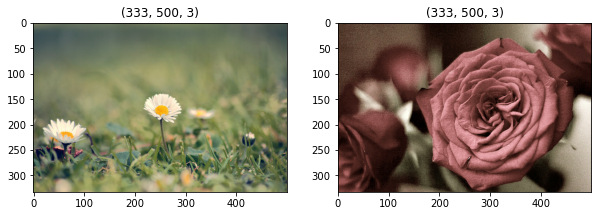

In [52]:
images_folder = 'sample_images'
raw_images = [tf.io.read_file(os.path.join(images_folder, image_path))
              for image_path in os.listdir(images_folder)]

fig, axes = plt.subplots(nrows=1, ncols=len(raw_images), figsize=(10,10))
for axis, image in zip(axes.flat[0:], raw_images):
    decoded_image = tf.image.decode_image(image)
    axis.set_title(decoded_image.shape)
    axis.imshow(decoded_image.numpy())

The prediction client encapsulates gRPC interface to the [Prediction Service](https://cloud.google.com/ai-platform-unified/docs/reference/rpc/google.cloud.aiplatform.v1beta1#google.cloud.aiplatform.v1beta1.PredictionService.Predict). 

To pass a batch of images to the service, the batch needs to be packaged as a [PredictRequest](https://cloud.google.com/ai-platform-unified/docs/reference/rpc/google.cloud.aiplatform.v1beta1#google.cloud.aiplatform.v1beta1.PredictRequest) protocol buffer. The referenced link provides a detailed description of the schema of the PredictRequest message. On a high level the batch is represented as a list of instances, where each instance is a map of the form:
```
{input_name: value}
```

In our case the *input name* - as embedded in the `serving_default` signature - is `bytes_input`. Since we are sending raw binary images the *value* is a base 64 encoded representation of an image. So each instance (image) is represented by the following map

```
{'bytes_input': {'b64': b64_image}}
```
                        


In [106]:
encoded_images = [base64.b64encode(raw_image.numpy()).decode('utf-8') for raw_image in raw_images]
instances_list = [{input_name: {'b64': encoded_image}} for encoded_image in encoded_images]
instances = [json_format.ParseDict(s, Value()) for s in instances_list]

### Invoking the endpoint

You can now invoke the endpoint using the `predict` method.

In [107]:
response = prediction_client.predict(endpoint=endpoint_name, instances=instances, parameters=None)


## Cleaning up

To clean up all GCP resources used in this project, you can [delete the GCP
project](https://cloud.google.com/resource-manager/docs/creating-managing-projects#shutting_down_projects) you used for the tutorial.

Otherwise, you can delete the individual resources you created in this tutorial:

- Dataset
- Model
- Endpoint
- Cloud Storage Bucket

In [ ]:
print(dataset_name)
print(model_name)
print(endpoint_name)
print(deployed_model_id)

In [ ]:
delete_dataset = True
delete_model = True
undeploy_model = True
delete_endpoint = True
delete_bucket = True

# Undeploye the model
try:
    if undeploy_model:
        endpoint_client.undeploy_model(endpoint=endpoint_name,
                                       deployed_model_id=deployed_model_id,
                                       traffic_split={})
except Exception as e:
    print(e)
  
# Delete the endpoint using the AI Platform (Unified) fully qualified identifier for the endpoint
try:
    if delete_endpoint:
        endpoint_client.delete_endpoint(name=endpoint_name)
except Exception as e:
    print(e)
        
# Delete the model using the AI Platform (Unified) fully qualified identifier for the model
try:
    if delete_model:
        model_client.delete_model(name=model_name)
except Exception as e:
    print(e)
    

# Delete the dataset using the AI Platform (Unified) fully qualified identifier for the dataset
try:
    if delete_dataset:
        dataset_client.delete_dataset(name=dataset_name)
except Exception as e:
    print(e)

if delete_bucket and 'BUCKET_NAME' in globals():
    ! gsutil rm -r gs://$BUCKET_NAME

## Code snippets